In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM
import copy


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_trainrepeat.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
dec_withintask['acc_bytask'].shape

(7, 8, 3)

In [6]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### Compute binary classification accuracy for different sets of trials
Easy = furthest rows from boundary

Medium = closer rows to boundary, but still in main grid


In [7]:

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # use correct trials only here
        correct = np.array(l['subject_correct'])
        
        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # easy is the furthest from bound
            # medium is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
           
            # loop over ROIs
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                inds = is_main_grid & correct
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_allmaintrials[si,ri,ti,ii] = d;
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & correct
                                                          
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_easytrials[si,ri,ti,ii] = d;
                
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & correct
                                                      
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_medtrials[si,ri,ti,ii] = d;
                
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

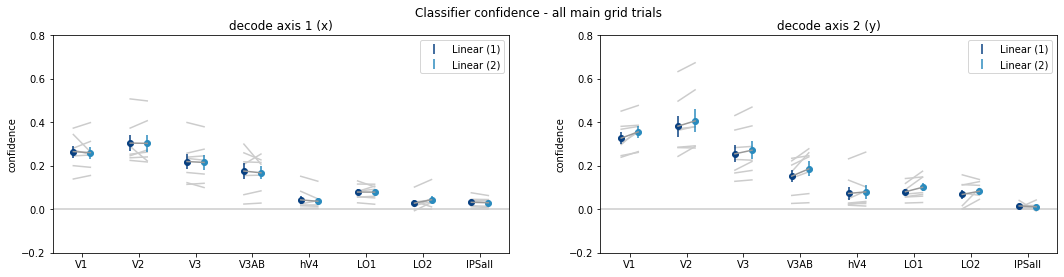

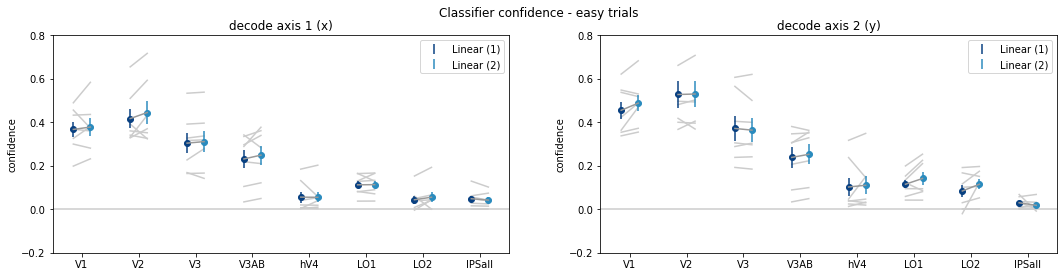

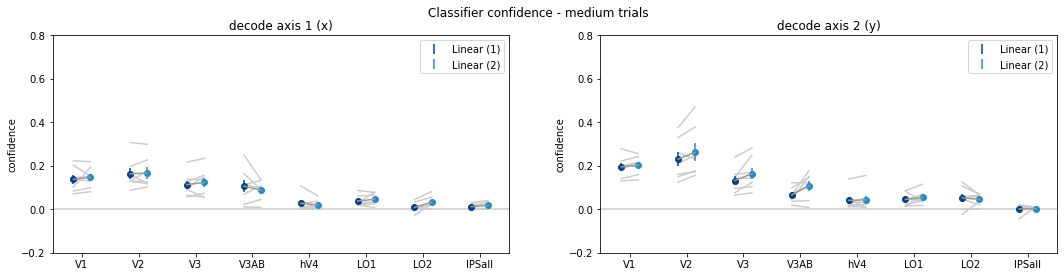

In [8]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):    
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Classifier confidence - %s'%name)


In [10]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials], \
                        ['easy','medium']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)
        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        print('\nAnova for confidence w/r/t %s, %s trials'%(axis_name, diffname))
        print(anova_result)



Anova for confidence w/r/t axis 1 (x), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       21.215212     7.0    42.0  0.0000
task       1.162345     1.0     6.0  0.3224
roi:task   0.654913     7.0    42.0  0.7082

Anova for confidence w/r/t axis 2 (y), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       23.040554     7.0    42.0  0.0000
task       1.969913     1.0     6.0  0.2100
roi:task   1.516553     7.0    42.0  0.1881

Anova for confidence w/r/t axis 1 (x), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       14.316424     7.0    42.0  0.0000
task       0.679580     1.0     6.0  0.4413
roi:task   1.194276     7.0    42.0  0.3270

Anova for confidence w/r/t axis 2 (y), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       20.853205     7.0    42.0  0.0000
task       8.044097     1.0     6.0  0.0297
roi:task   1.995016     7.0    42.0  0.0786


#### compute Checker Task accuracy for different sets of trials
Easy, Med, Hard are all in main grid, different positions relative to boundaries


In [16]:
conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_hardtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist_from_center = l['dist_from_center'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist_from_center[is_main_grid])
        
        is_hard = is_main_grid & (dist_from_center==un_dist[0])
        is_medium = is_main_grid & (dist_from_center==un_dist[1])
        is_easy = is_main_grid & (dist_from_center==un_dist[2])
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            
            inds = is_main_grid & correct
                
            conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_allmaintrials[si,ri,ti,ii] = d;

            acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # easy trials
            inds = is_easy & correct

            conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_easytrials[si,ri,ti,ii] = d;

            acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # medium trials
            inds = is_medium & correct

            conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_medtrials[si,ri,ti,ii] = d;

            acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # hard trials
            inds = is_hard & correct

            conf_hardtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_hardtrials[si,ri,ti,ii] = d;

            acc_hardtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


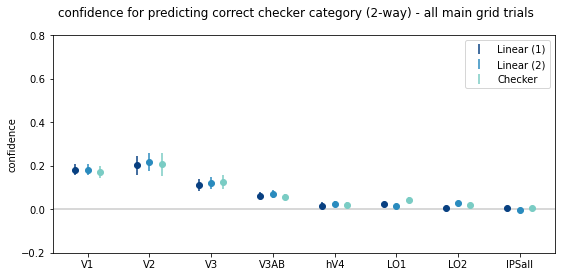

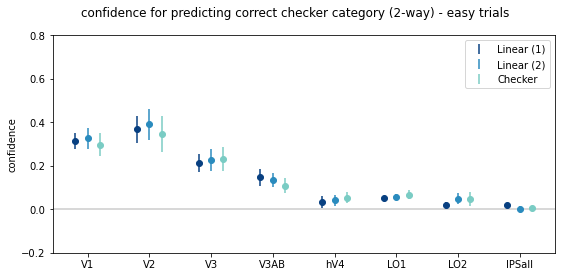

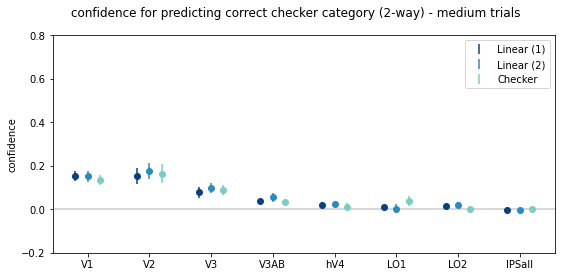

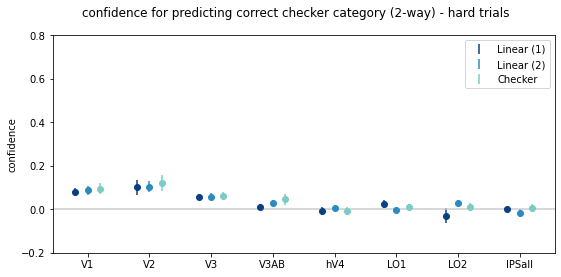

In [17]:
ti_plot = [0,1,2]

x_jitter = np.linspace(-0.2, 0.2, 3)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['all main grid trials', 'easy trials','medium trials', 'hard trials']):

    plt.figure(figsize=(9,4))

    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 0.8])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)


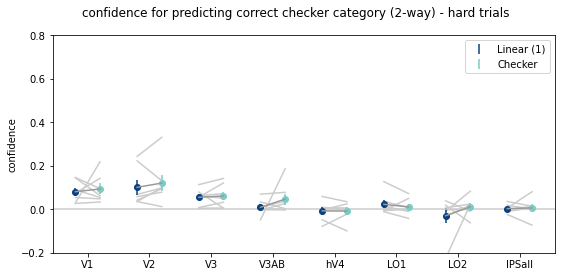

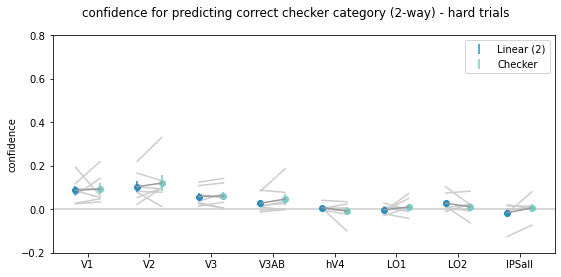

In [19]:
for ti_plot in [[0,2],[1,2]]:


    x_jitter = np.linspace(-0.2, 0.2, 2)

    for rvals, name in zip([conf_hardtrials], \
                         ['hard trials']):

        plt.figure(figsize=(9,4))

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for tii, ti in enumerate(ti_plot):

            x_ticks = np.arange(n_rois) + x_jitter[tii]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)

        for ri in range(n_rois):

            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)


        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)
